# Facebook Prophet
- Author: Kimberly Yeo
- Module: Capstone
- Date: 2/11/2021

## Import packages

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from arch import arch_model
from arch.univariate import ARCH, GARCH, ConstantMean, Normal
from sklearn.metrics import mean_absolute_error, mean_squared_error

Importing plotly failed. Interactive plots will not work.


## Load data

For later iterations and testing, use cctx (it supports live data and multiple exchanges (best one is ftx)).

In [2]:
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-29,6643.100098,6643.100098,6511.649902,6601.959961,6601.959961,4.363690e+09
1,2018-09-30,6604.709961,6643.779785,6566.540039,6625.560059,6625.560059,4.002280e+09
2,2018-10-01,6619.850098,6653.299805,6549.080078,6589.620117,6589.620117,4.000970e+09
3,2018-10-02,6593.240234,6611.839844,6537.899902,6556.100098,6556.100098,3.979260e+09
4,2018-10-03,6553.859863,6571.459961,6454.029785,6502.589844,6502.589844,3.887310e+09


In [3]:
# Calculate daily returns as percentage price changes
df["Return"] = 100 * (df["Adj Close"].pct_change())
df["Log_Return"] = np.log(df["Adj Close"]).diff().mul(100) # rescale to faciliate optimization
df = df.dropna()

In [4]:
data = df[["Date", "Return"]]
data = data.set_index(data.columns[0])
data.head()

,Return
Date,
2018-09-30,0.357471
2018-10-01,-0.542444
2018-10-02,-0.508679
2018-10-03,-0.816190
2018-10-04,1.139547


## EDA

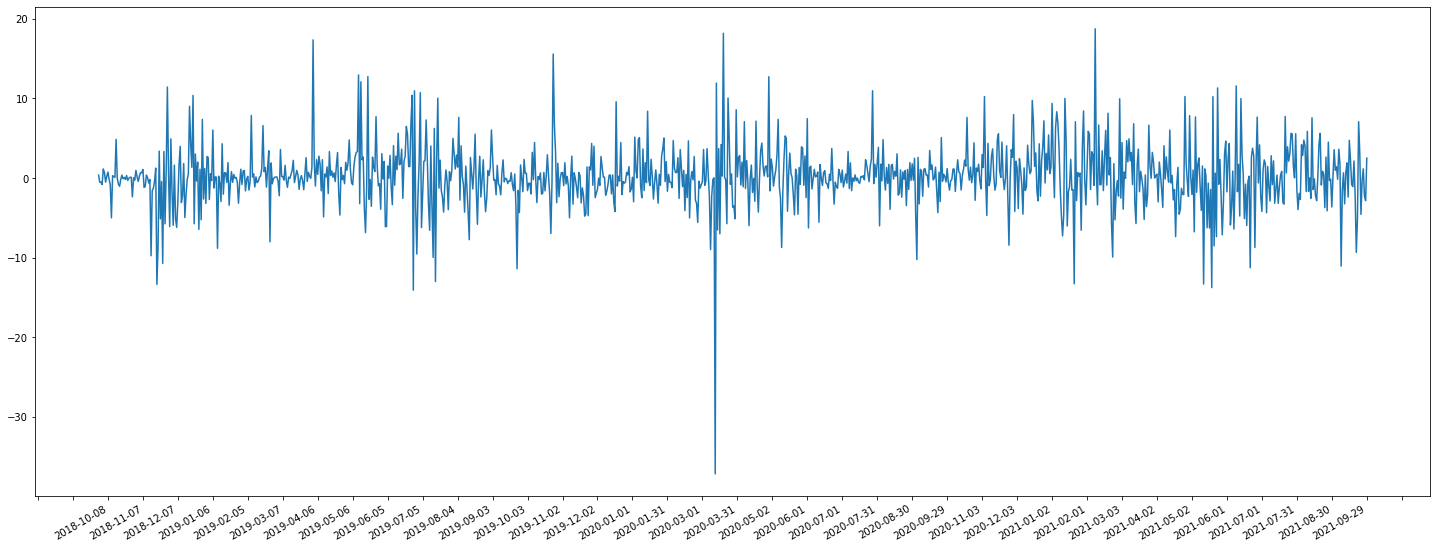

In [5]:
# Plot daily returns
plt.figure(figsize = [25, 10])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(data)
plt.gcf().autofmt_xdate()
plt.show()

## Forecasting Using Facebook Prophet

In [6]:
# Calculate the observed variance
obs_vol = np.sqrt(data.sub(data.mean()).pow(2))

In [7]:
# Change column names to fit prophet requirements
obs_vol = obs_vol.reset_index()
obs_vol = obs_vol.rename(columns={'Date': 'ds', 'Return': 'y'})

In [8]:
time_horizon = 6

In [9]:
train = obs_vol[:-time_horizon].dropna()
test = obs_vol[-time_horizon:].dropna()

In [10]:
test

,ds,y
1083,2021-09-24,4.821081
1084,2021-09-25,0.530450
1085,2021-09-26,0.908680
1086,2021-09-27,2.494396
1087,2021-09-28,3.086977
1088,2021-09-29,2.250138


In [11]:
# Define the model
model = Prophet()
# Fit the model
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
# Use the model to make a forecast
forecast = model.predict(pd.DataFrame(test['ds']))
# Summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds      yhat  yhat_lower  yhat_upper
0 2021-09-24  2.417923   -1.161198    5.986550
1 2021-09-25  1.627137   -2.049883    5.114454
2 2021-09-26  2.015484   -1.626907    5.535217
3 2021-09-27  3.077229   -0.434895    6.416091
4 2021-09-28  2.325754   -1.318615    5.850787


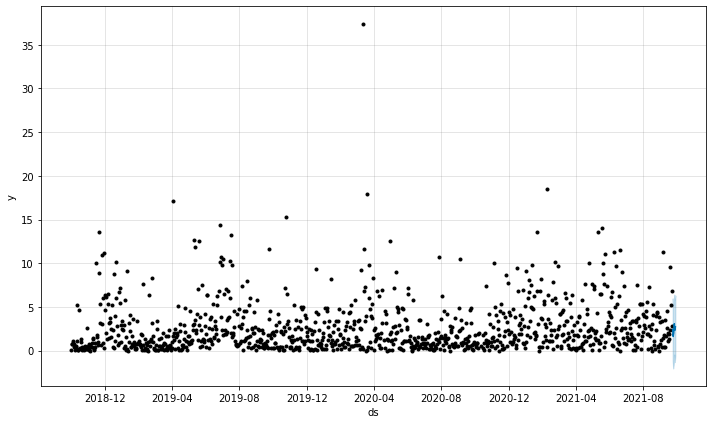

In [13]:
# Plot the forecast
model.plot(forecast)
plt.show()

In [14]:
# Calculate MAE between expected and predicted values for test data
y_true = test['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

MAE: 1.069
MSE: 1.556


The MAE value is lower when compared to those of ARCH and GARCH models.

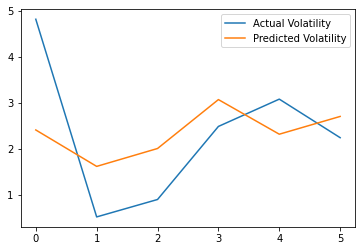

In [16]:
# Plot expected vs actual
plt.plot(y_true, label='Actual Volatility')
plt.plot(y_pred, label='Predicted Volatility')
plt.legend()
plt.show()

It appears the model has trouble predicting large swings in volatility.

In [14]:
# Incorporating uncertainty in the trend
forecast = Prophet(interval_width=0.95).fit(train).predict(pd.DataFrame(test['ds']))


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


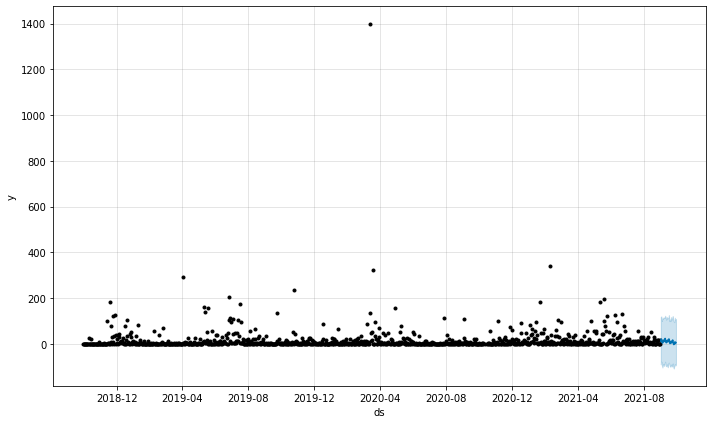

In [15]:
# Plot the forecast
model.plot(forecast)
plt.show()

In [ ]:
# Incorporating uncertainty in seasonality
m = Prophet(mcmc_samples=300)
forecast = m.fit(train).predict(pd.DataFrame(test['ds']))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
fig = m.plot_components(pd.DataFrame(test['ds']))